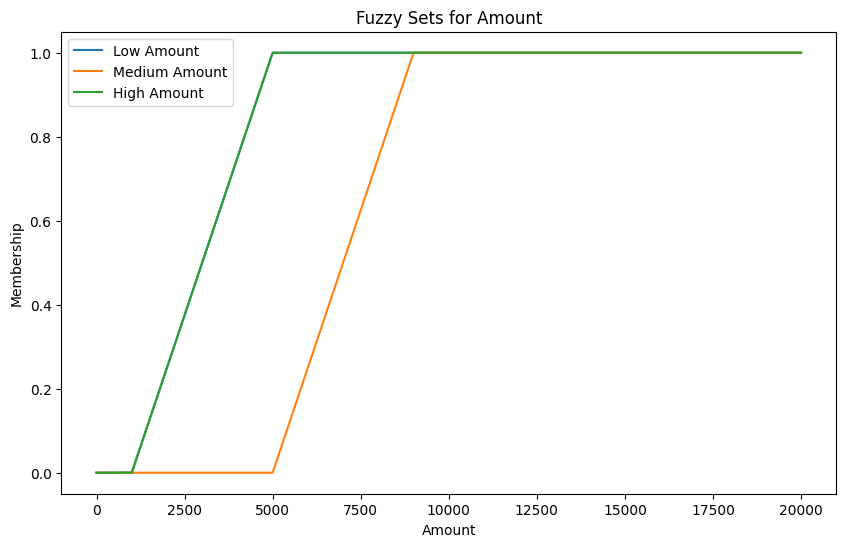

           amount  oldbalanceOrg  newbalanceOrig  isFraud  fraud_predicted
0         9839.64      170136.00       160296.36      0.0                0
1         1864.28       21249.00        19384.72      0.0                0
2          181.00         181.00            0.00      1.0                1
3          181.00         181.00            0.00      1.0                1
4        11668.14       41554.00        29885.86      0.0                0
...           ...            ...             ...      ...              ...
641460   42165.40     1886754.71      1928920.11      0.0                0
641461   42823.69     1928920.11      1971743.80      0.0                0
641462   17840.01       79874.00        62033.99      0.0                0
641463    7555.37         413.00            0.00      0.0                1
641464  123374.89       46973.00            0.00      NaN                1

[641465 rows x 5 columns]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


df = pd.DataFrame(new_df)


def fuzzy_membership(x, low, high):
    if x < low:
        return 0
    elif low <= x < high:
        return (x - low) / (high - low)
    else:
        return 1


low_threshold_amount = 1000
high_threshold_amount = 5000

low_threshold_balance = 10000
high_threshold_balance = 50000

df['amount_membership'] = df['amount'].apply(lambda x: fuzzy_membership(x, low_threshold_amount, high_threshold_amount))
df['oldbalance_membership'] = df['oldbalanceOrg'].apply(lambda x: fuzzy_membership(x, low_threshold_balance, high_threshold_balance))
df['newbalance_membership'] = df['newbalanceOrig'].apply(lambda x: fuzzy_membership(x, 0, 1))

x = np.linspace(0, 20000, 1000)
low = np.maximum(0, np.minimum(1, (x - low_threshold_amount) / (high_threshold_amount - low_threshold_amount)))
medium = np.maximum(0, np.minimum(1, (x - high_threshold_amount) / (high_threshold_amount - low_threshold_amount)))
high = np.maximum(0, np.minimum(1, (x - low_threshold_amount) / (high_threshold_amount - low_threshold_amount)))
plt.figure(figsize=(10, 6))
plt.plot(x, low, label='Low Amount')
plt.plot(x, medium, label='Medium Amount')
plt.plot(x, high, label='High Amount')
plt.title('Fuzzy Sets for Amount')
plt.xlabel('Amount')
plt.ylabel('Membership')
plt.legend()
plt.show()

def predict_fraud(row):
    if row['amount_membership'] > 0.7 and row['oldbalance_membership'] < 0.2:
        return 1
    elif row['newbalance_membership'] < 0.1:
        return 1
    else:
        return 0

df['fraud_predicted'] = df.apply(predict_fraud, axis=1)




# **Genetic Algorithm**

Missing values in the dataset:
 type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
isFraud           0
dtype: int64
Generation 1/10
Generation 2/10
Generation 3/10
Generation 4/10
Generation 5/10
Generation 6/10
Generation 7/10
Generation 8/10
Generation 9/10
Generation 10/10


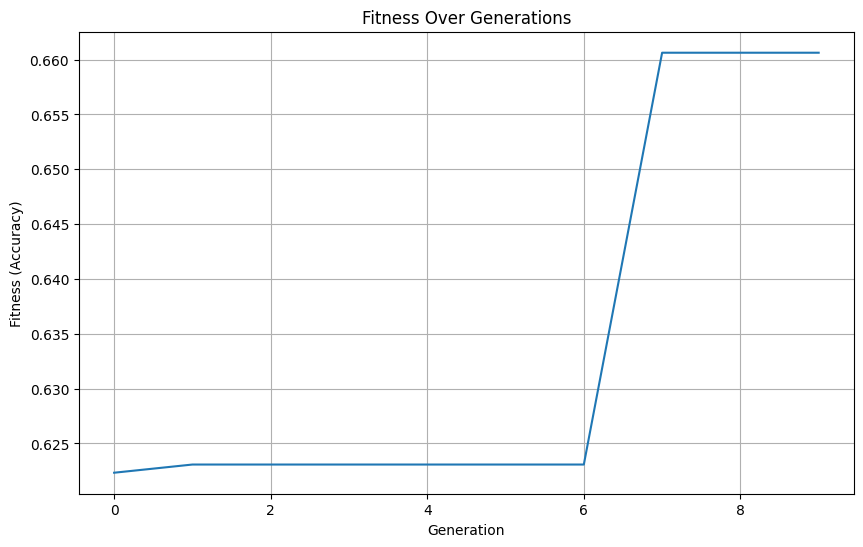

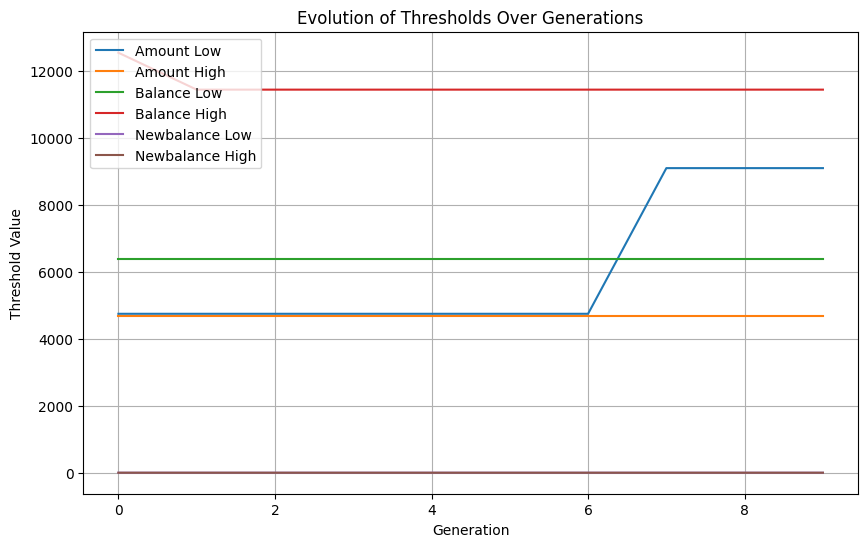

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

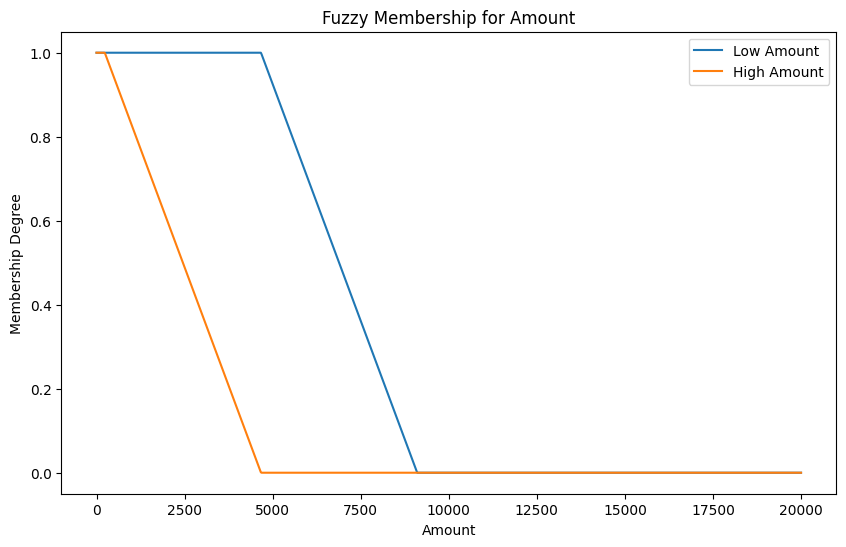

In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

df = pd.DataFrame(new_df)
df['newbalanceOrig'] = df['newbalanceOrig'].fillna(df['newbalanceOrig'].median())
df['isFraud'] = df['isFraud'].fillna(df['isFraud'].mode()[0])
df = df.dropna()
print("Missing values in the dataset:\n", df.isna().sum())

def fuzzy_membership(x, low, high):
    if x < low:
        return 0
    elif low <= x < high:
        return (x - low) / (high - low)
    else:
        return 1

def fitness_function(individual, df):
    amount_low, amount_high, balance_low, balance_high, newbalance_low, newbalance_high = individual
    df['amount_membership'] = df['amount'].apply(lambda x: fuzzy_membership(x, amount_low, amount_high))
    df['oldbalance_membership'] = df['oldbalanceOrg'].apply(lambda x: fuzzy_membership(x, balance_low, balance_high))
    df['newbalance_membership'] = df['newbalanceOrig'].apply(lambda x: fuzzy_membership(x, newbalance_low, newbalance_high))
    df['fraud_predicted'] = df.apply(lambda row: 1 if row['amount_membership'] > 0.7 and row['oldbalance_membership'] < 0.2 else 0, axis=1)
    df['fraud_predicted'] = df['fraud_predicted'].fillna(0)
    accuracy = accuracy_score(df['isFraud'], df['fraud_predicted'])
    return accuracy

def create_initial_population(pop_size, param_range):
    population = []
    for _ in range(pop_size):
        individual = [
            random.uniform(*param_range['amount']),
            random.uniform(*param_range['amount']),
            random.uniform(*param_range['balance']),
            random.uniform(*param_range['balance']),
            random.uniform(*param_range['newbalance']),
            random.uniform(*param_range['newbalance'])
        ]
        population.append(individual)
    return population

def selection(population, fitness_scores, num_parents):
    parents = np.array(population)[np.argsort(fitness_scores)[-num_parents:]]
    return parents

def crossover(parents, crossover_rate=0.7):
    offspring = []
    num_offspring = len(parents)
    for i in range(0, num_offspring, 2):
        parent1 = parents[i]
        parent2 = parents[i+1] if i+1 < num_offspring else parents[i]
        if random.random() < crossover_rate:
            crossover_point = random.randint(1, len(parent1)-1)
            offspring.append(np.concatenate([parent1[:crossover_point], parent2[crossover_point:]]))
            offspring.append(np.concatenate([parent2[:crossover_point], parent1[crossover_point:]]))
        else:
            offspring.append(parent1)
            offspring.append(parent2)
    return offspring

def mutation(offspring, mutation_rate=0.1, param_range=None):
    for individual in offspring:
        if random.random() < mutation_rate:
            mutation_index = random.randint(0, len(individual)-1)
            new_value = (
                random.uniform(*param_range['amount']) if mutation_index < 2
                else random.uniform(*param_range['balance']) if mutation_index < 4
                else random.uniform(*param_range['newbalance'])
            )
            individual[mutation_index] = new_value
    return offspring

def genetic_algorithm(df, pop_size=10, generations=10, crossover_rate=0.7, mutation_rate=0.1):
    param_range = {
        'amount': (1000, 10000),
        'balance': (5000, 50000),
        'newbalance': (0, 1)
    }
    population = create_initial_population(pop_size, param_range)
    best_accuracy = 0
    best_individual = None
    fitness_scores_over_generations = []
    best_individuals_over_generations = []
    for generation in range(generations):
        print(f"Generation {generation+1}/{generations}")
        fitness_scores = [fitness_function(individual, df) for individual in population]
        best_gen_individual = population[np.argmax(fitness_scores)]
        best_gen_accuracy = max(fitness_scores)
        fitness_scores_over_generations.append(best_gen_accuracy)
        best_individuals_over_generations.append(best_gen_individual)
        if best_gen_accuracy > best_accuracy:
            best_accuracy = best_gen_accuracy
            best_individual = best_gen_individual
        parents = selection(population, fitness_scores, num_parents=int(pop_size/2))
        offspring = crossover(parents, crossover_rate)
        offspring = mutation(offspring, mutation_rate, param_range)
        population = parents.tolist() + offspring
    return best_individual, best_accuracy, fitness_scores_over_generations, best_individuals_over_generations

best_individual, best_accuracy, fitness_scores_over_generations, best_individuals_over_generations = genetic_algorithm(df, pop_size=20, generations=10)

plt.figure(figsize=(10, 6))
plt.plot(fitness_scores_over_generations)
plt.title("Fitness Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.grid(True)
plt.show()

best_individuals_over_generations = np.array(best_individuals_over_generations)
plt.figure(figsize=(10, 6))
plt.plot(best_individuals_over_generations[:, 0], label="Amount Low")
plt.plot(best_individuals_over_generations[:, 1], label="Amount High")
plt.plot(best_individuals_over_generations[:, 2], label="Balance Low")
plt.plot(best_individuals_over_generations[:, 3], label="Balance High")
plt.plot(best_individuals_over_generations[:, 4], label="Newbalance Low")
plt.plot(best_individuals_over_generations[:, 5], label="Newbalance High")
plt.title("Evolution of Thresholds Over Generations")
plt.xlabel("Generation")
plt.ylabel("Threshold Value")
plt.legend()
plt.grid(True)
plt.show()

amount_low, amount_high, balance_low, balance_high, newbalance_low, newbalance_high = best_individual
x = np.linspace(0, 20000, 1000)
low_amount = np.maximum(0, np.minimum(1, (x - amount_low) / (amount_high - amount_low)))
high_amount = np.maximum(0, np.minimum(1, (x - amount_high) / (amount_high - amount_low)))

plt.figure(figsize=(10, 6))
plt.plot(x, low_amount, label='Low Amount')
plt.plot(x, high_amount, label='High Amount')
plt.title('Fuzzy Membership for Amount')
plt.xlabel('Amount')
plt.ylabel('Membership Degree')
plt.legend()
plt.show()
